# **V**ariational **A**uto**E**ncoder

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

The Variational Autoencoder was introduced in 2013 by Kingma and Welling at the 2nd International Conference on Learning Representations. VAE are powerful generative models.<br>
We learned in the lecture that a segmentation CNN has an "hourglass" structure with a decoder that maps an image to the network and an encoder part that constructs the image (see below).

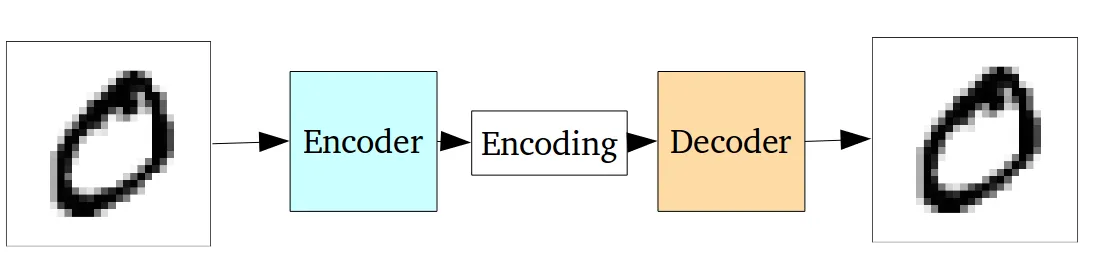

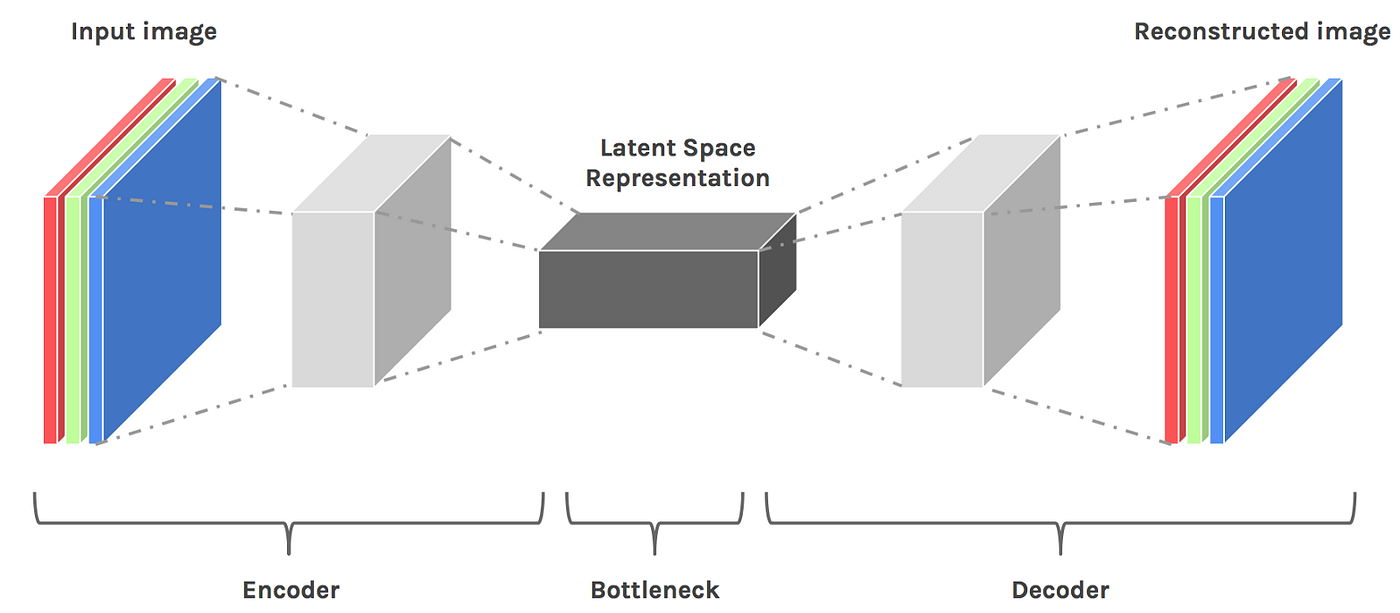

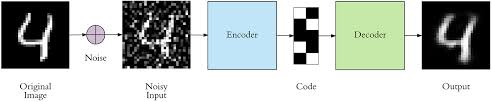

We can use this structure for<br> 
- image segmentation where the reconstructed image passes a softmax layer so that we can derive probabilities for each pixel for each class and compare it to the ground truth (i.e. a labelled image)<br>
  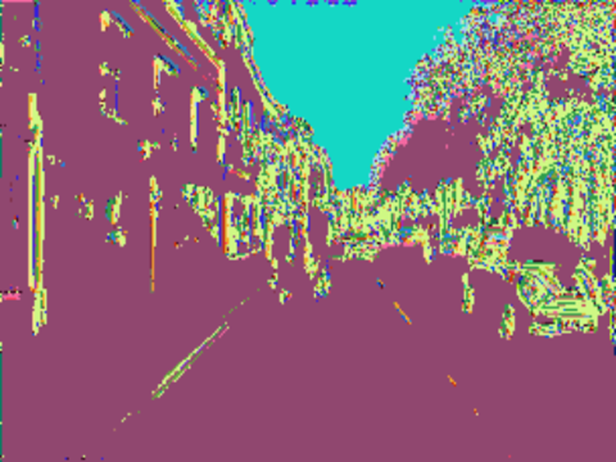 (reconstructed label)
  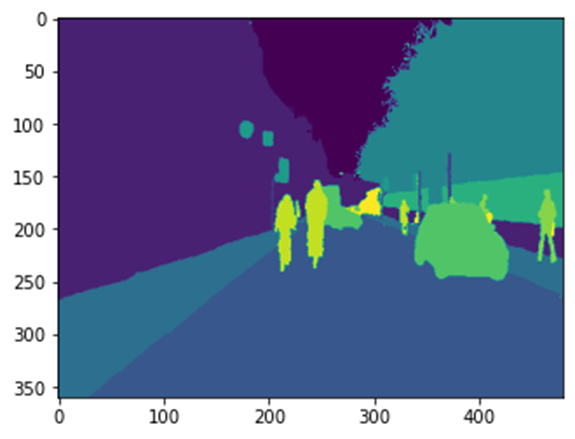 (ground truth)
- image generation via a GAN (see *GAN architecture* notebook), where we split the encoder (aka *discriminator*) part for discriminating between real images from fake images, from the decoder (aka *generator*) part, which generates images by up-sampling, i. d. decoding, a latent vector to an image.  

<!-- Whats the issue with VAE?
The fundamental problem with autoencoders, for generation, is that the latent space they convert their inputs to and where their encoded vectors lie, may not be continuous, or allow easy interpolation. -->

The image gets encoded in the down-sampling part, flattened and then encoded in the dense layer in the bottleneck. The idea of a VAE is that we can approximate a **distribution of the latent space variables** and then draw (i. e.) **sample from this distribution** in order to generate new, but similar images.<br> 
For example we can train the network with cat images. Then, the network has encoded the information "cat" in the latent space. Since cats might have different colors, can be of different kind etc., each latent variable is now represented by a distribution which reflects the variety of the information "cat".<br>
For a GAN, we generated **z** of length *latent_dim* randomly before passing it on to the generator part. Eventough *z* was generated randomly, it was still **one vector for one specific image**, but **now we want to draw the values in z from a distribution** for **each image** hence this **distribution corresponds to one specific image**.<br>

<br>

## 1) Loading Libraries and Dataset

We load the standard keras/tensorflow libraries and the mnist data set: 

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, backend as K
from tensorflow.keras.datasets import mnist

Next, we preprocess the mnist dataset as usual

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train  = x_train.astype('float32') / 255.0
x_test   = x_test.astype('float32') / 255.0
x_train  = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test   = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [18]:
print(x_test.shape)

(10000, 28, 28, 1)


and plot a few images:

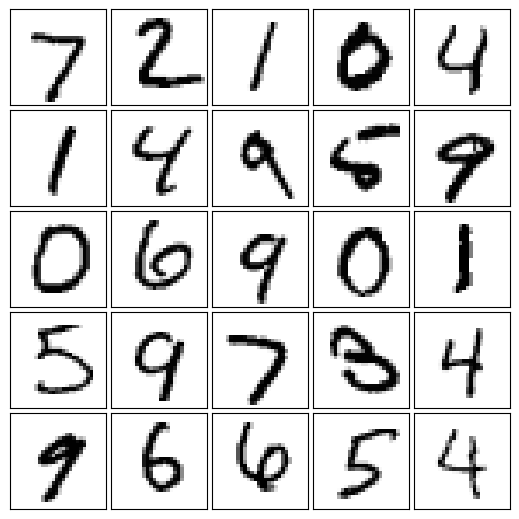

In [29]:
fig = plt.figure(figsize = (5, 5))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for i in range(25):
     ax = fig.add_subplot(5, 5, i + 1, xticks = [], yticks = [])
     ax.imshow(-x_test[i,:,:] + np.max(x_test[0,:,:]), cmap = 'gray', interpolation = 'nearest')

In [33]:
input_shape = x_test.shape[1:]
print(input_shape)

(28, 28, 1)


<br>

## 2) Building Encoder and Decoder

2.1) We start with building the *encoder*, which is just a sequential down-sampling CNN. As an input, it takes the shape of the training images and the number of dimensions we want the have for the latent space vector.

In [11]:
def Encoder(input_shape, latent_dim):

    encoder = models.Sequential(name = "encoder")

    encoder.add(layers.InputLayer(input_shape = input_shape))

    # CNN part
    encoder.add(layers.Conv2D(32, (3, 3), activation="relu", strides=2, padding="same"))
    encoder.add(layers.Conv2D(64, (3, 3), activation="relu", strides=2, padding="same"))

    # flatten and dense projection
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(16, activation = "relu"))

    # Latent outputs
    z_mean_layer    = layers.Dense(latent_dim, name = "z_mean")
    z_log_var_layer = layers.Dense(latent_dim, name = "z_log_var") # log variance for numerical reasons

    return encoder, z_mean_layer, z_log_var_layer

What is the purpose of the last two lines in the encoder?<br>
We don't know the distribution of any of the latent variables, so we need to generate $\mu$ and $\sigma$ each from a **separate** dense layer. Those layers have learnables (weights/biases), so that during the training process, the estimates for $\mu$ and $\sigma$ get better each time.<br>
The variable *latent_dim* tells how many $\mu$ and $\sigma$ we want to generate for each image.<br>
Recall how we generated **z** of length *latent_dim* randomly for the generator part of a GAN. Eventough *z* was generated randomly, it was still **one vector for one specific image**, but **now we want to draw the values in z from a distribution** and this **distribution corresponds to one specific image**.<br>
Having $\mu$ and $\sigma$ we now can draw values for *z* by assuming $z_i \sim N(\mu_i, \sigma_i^2)$ where *i* refers to the dimensions in *z*. 

<br>

2.2) Now, we define the *decoder* which up-samples the latent vector *z* to an image:

In [12]:
def Decoder(input_shape, latent_dim):
    """
    Builds a convolutional decoder that mirrors an encoder with two Conv2D(strides=2) layers.
    Works for any input size (not necessarily divisible by 4).
    """

    h, w, c = input_shape
    feature_channels = 64  # matches last encoder conv output channels

    # computes approximate spatial size after two downsamples
    reduced_h = int(np.ceil(h / 4))
    reduced_w = int(np.ceil(w / 4))

    decoder = models.Sequential(name="decoder")

    # Latent vector input
    decoder.add(layers.InputLayer(input_shape=(latent_dim,)))

    # Dense + reshape
    decoder.add(layers.Dense(reduced_h * reduced_w * feature_channels, activation="relu"))
    decoder.add(layers.Reshape((reduced_h, reduced_w, feature_channels)))

    # Deconvolution (reverse of encoder)
    decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu"))
    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu"))
    decoder.add(layers.Conv2DTranspose(c, (3, 3), activation="sigmoid", padding="same"))

    # Resize output to match the encoder input size exactly
    decoder.add(layers.Lambda(lambda x: tf.image.resize(x, (h, w))))

    return decoder

The *encoder* returns the vectors for $\mu$ and $\sigma$ from which we can sample *z* in order to pass it on to the *decoder*. Therefore, it makes sense to define a sampling function.

In [13]:
class SamplingForZ(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon           = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Note that the sampling function does not just sample from $N(\mu_i, \sigma_i^2)$, but rather via $z_i = \mu + \sigma \cdot \epsilon$, where $\epsilon \sim N(0,1)$. The reason is that $\mu_i$ and $\sigma_i$ were generated from an deterministic network and we need to run backpropagation (which is deterministic) through these variables in order to adjust the weights and biases in the last dense layers of the encoder. That would defy the entire idea of generating *z* randomly in the first place. Thus, $\epsilon$, which is not generated by the network and therefore not affected by backpropagation, keeps the randomnes.

<br>

2.3) Having the *encoder*, the *decoder* and the sampling function, we can now construct the entire VAE:

In [19]:
def VAE(input_shape, latent_dim):
    
    encoder_base, z_mean_layer, z_log_var_layer = Encoder(input_shape, latent_dim)

    inputs    = layers.Input(shape = input_shape)
    x         = encoder_base(inputs)
    z_mean    = z_mean_layer(x)
    z_log_var = z_log_var_layer(x)
    z         = SamplingForZ()([z_mean, z_log_var])

    decoder = Decoder(input_shape, latent_dim)
    outputs = decoder(z)

    vae = models.Model(inputs, outputs, name = "VAE")
    return vae, encoder_base, decoder, z_mean_layer, z_log_var_layer

<br>

2.4) Finally we just need the loss function which in this case is the KL - divergence (see lecture "Variational Bayes")

In [21]:
def Loss(x, x_recon, z_mean, z_log_var):
    
    recon_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(x, x_recon), axis = (1, 2)))
    kl_loss    = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis = 1))
    
    return recon_loss + kl_loss, recon_loss, kl_loss

<br>

# 3) Training

We are ready for the training now. In order to visualize how well the network maps the data to the latent space we generate a few reconstructed images and also generate completely new, unseen images from the fully trained network. Additionaly, we like to visualize the location of the image classes in the latent space. If the length of the latent vector is choosen to be larger than 2D, we project the latenspace using PCA.  

In [25]:
def EmbeddingTo2D(embed):
    """
    embed: (N, D) numpy array
    returns: (N,2) numpy array of 2 principal components
    """
    embed     = embed - np.mean(embed, axis = 0, keepdims = True)
    ## compute SVD on covariance via compact trick
    u, s, vt  = np.linalg.svd(embed, full_matrices = False)
    comps     = vt[:2].T  # D x 2
    projected = embed.dot(comps)  # N x 2
    return projected

Finally, we are ready for the training part. Note that I have added a few plotting routinese that:<br>
- show a few reconstructued images, see 1)
- generate new, unseen images from sampling from the trained VAE, see 2); and
- plots the location ($\mu_z$) of the different image classes in the latent space, see 3). Similar images should be located in the same region of the latent space.    

In [36]:
def TrainEvalVisualize(x_train, y_train, x_test, y_test, latent_dim = 5, epochs = 10, batch_size = 128, num_recon = 10, num_gen = 15):
    #num_recon: number of images to be reconstruted
    #num_gen: number of images to be generated 
    
    input_shape = x_train.shape[1:]  # (H,W,C)

    # call VAE model
    vae_model, encoder_base, decoder, z_mean_layer, z_log_var_layer = VAE(input_shape, latent_dim)

    # call Adam optimizer
    optimizer = optimizers.Adam()

    # generate shuffled training data
    train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

    # training loop
    for epoch in range(1, epochs + 1):
        epoch_total = 0.0
        epoch_recon = 0.0
        epoch_kl    = 0.0
        n_batches   = 0
        
        for step, batch_x in enumerate(train_ds):
            #tf.GradientTape() needed when including custom loss functions 
            with tf.GradientTape() as tape:
                
                # encode
                enc_feats = encoder_base(batch_x)                   # (batch, features)
                z_mean    = z_mean_layer(enc_feats)                 # (batch, latent_dim)
                z_log_var = z_log_var_layer(enc_feats)              # (batch, latent_dim)
                
                # sample
                z         = SamplingForZ()([z_mean, z_log_var])
                
                # decode
                x_recon   = decoder(z)
                
                # loss
                total_loss, recon_loss, kl_loss = Loss(batch_x, x_recon, z_mean, z_log_var)

            grads = tape.gradient(total_loss, vae_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae_model.trainable_weights))

            epoch_total += float(total_loss)
            epoch_recon += float(recon_loss)
            epoch_kl    += float(kl_loss)
            n_batches   += 1

        print(f"Epoch {epoch}/{epochs} — loss: {epoch_total/n_batches:.4f} | recon: {epoch_recon/n_batches:.4f} | kl: {epoch_kl/n_batches:.4f}")

    #################################################################################
    # ----------------------------
    # 1) Reconstruction: show original vs reconstructed
    # ----------------------------
    idx       = np.random.choice(len(x_test), size=num_recon, replace=False)
    origs     = x_test[idx]
    enc_feats = encoder_base(origs)
    z_mean    = z_mean_layer(enc_feats)
    z_log_var = z_log_var_layer(enc_feats)         # * epsilon
    z         = z_mean + tf.exp(0.5 * z_log_var) * tf.random.normal(tf.shape(z_mean))
    recons    = decoder.predict(z)

    plt.figure(figsize=(num_recon * 2, 4))
    for i in range(num_recon):
        ax = plt.subplot(2, num_recon, i + 1)
        plt.imshow(origs[i].squeeze(), cmap = "gray")
        ax.axis("off")
        ax = plt.subplot(2, num_recon, num_recon + i + 1)
        plt.imshow(recons[i].squeeze(), cmap = "gray")
        ax.axis("off")
    plt.suptitle("Top: original | Bottom: reconstruction")
    plt.show()
    #################################################################################

    #################################################################################
    # ----------------------------
    # 2) Generation: sample new images from prior N(0,I)
    # ----------------------------
    random_z = np.random.normal(size=(num_gen, latent_dim)).astype("float32")
    gen_imgs = decoder.predict(random_z)

    plt.figure(figsize=(num_gen, 2))
    for i in range(num_gen):
        ax = plt.subplot(1, num_gen, i + 1)
        plt.imshow(gen_imgs[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.suptitle("generated samples (z ~ N(0,I))")
    plt.show()
    #################################################################################

    #################################################################################
    # ----------------------------
    # 3) Latent space visualization
    # ----------------------------
    # Encode entire test set (or a subset)
    subset     = 2000
    enc_x      = x_test[:subset]
    enc_feats  = encoder_base(enc_x)
    z_mean_all = z_mean_layer(enc_feats).numpy()   # shape (subset, latent_dim)
    labels     = y_test[:subset]

    if latent_dim == 2:
        z_for_plot = z_mean_all
    else:
        z_for_plot = EmbeddingTo2D(z_mean_all)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(z_for_plot[:, 0], z_for_plot[:, 1], c=labels, cmap="tab10", s=6, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    #sns.kdeplot(x = z_for_plot[:, 0], y = z_for_plot[:, 1], fill = True, cmap = "viridis", thresh = 0, levels = 100, alpha = 0.6)
    plt.title("latent space (z_mean) visualization (PCA->2D if latent_dim>2)")
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.show()
    #################################################################################

    # If latent_dim == 2: also show a grid of decoded images over a 2D grid
    if latent_dim == 2:
        n      = 15
        grid_x = np.linspace(-3, 3, n)
        grid_y = np.linspace(-3, 3, n)
        figure = np.zeros((input_shape[0] * n, input_shape[1] * n))
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample  = np.array([[xi, yi]], dtype="float32")
                x_decoded = decoder.predict(z_sample)
                digit     = x_decoded[0].reshape(input_shape[0], input_shape[1])
                figure[i * input_shape[0] : (i + 1) * input_shape[0],
                       j * input_shape[1] : (j + 1) * input_shape[1]] = digit
        plt.figure(figsize=(8, 8))
        plt.imshow(figure, cmap="gray")
        plt.title("Decoded grid from 2D latent space")
        plt.axis("off")
        plt.show()

    return { "vae": vae_model, "encoder_base": encoder_base, "decoder": decoder, "z_mean_layer": z_mean_layer, "z_log_var_layer": z_log_var_layer}

Epoch 1/6 — loss: 204.0031 | recon: 198.2486 | kl: 5.7545
Epoch 2/6 — loss: 144.4992 | recon: 134.6508 | kl: 9.8484
Epoch 3/6 — loss: 131.7251 | recon: 120.4851 | kl: 11.2399
Epoch 4/6 — loss: 127.8061 | recon: 116.3706 | kl: 11.4355
Epoch 5/6 — loss: 125.8575 | recon: 114.2904 | kl: 11.5671
Epoch 6/6 — loss: 124.6726 | recon: 113.0129 | kl: 11.6597
1/1 [==============================] - 0s 107ms/step


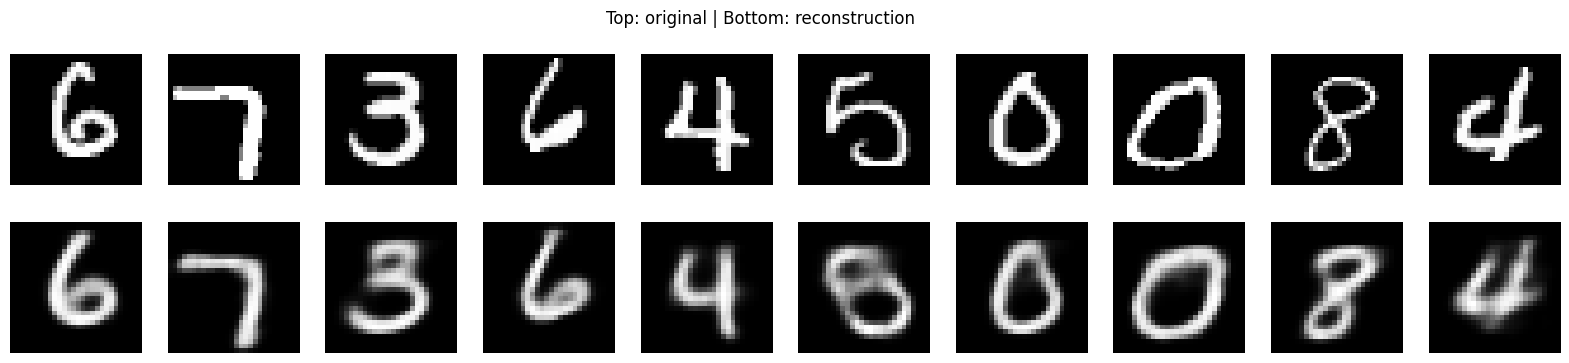

1/1 [==============================] - 0s 57ms/step


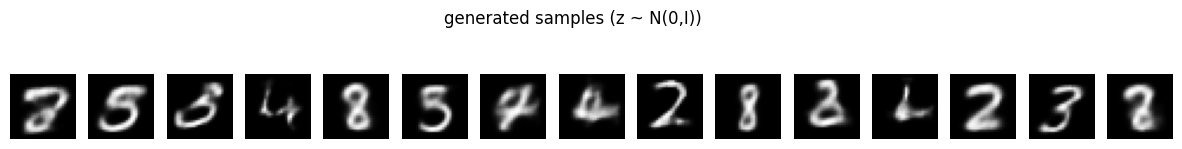

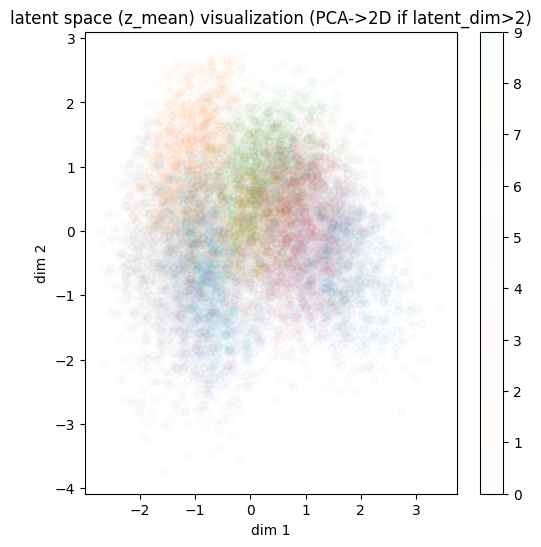

In [38]:
R = TrainEvalVisualize(x_train, y_train, x_test, y_test, latent_dim = 5, epochs = 6, batch_size = 128)